In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.5 MB/s eta 0:00:00


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
import wandb

In [4]:
def conv_bn(inp, oup, stride):
    """
    Creates a convolutional layer followed by batch normalization and ReLU activation.

    Parameters:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride for the convolution operation.

    Returns:
        nn.Sequential: A sequence of layers consisting of Conv2d, BatchNorm2d, and ReLU6.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),  # 3x3 convolution
        nn.BatchNorm2d(oup),  # Batch normalization
        nn.ReLU6(inplace=True)  # ReLU activation
    )

def conv_1x1_bn(inp, oup):
    """
    Creates a 1x1 convolutional layer followed by batch normalization and ReLU activation.

    Parameters:
        inp (int): Number of input channels.
        oup (int): Number of output channels.

    Returns:
        nn.Sequential: A sequence of layers consisting of Conv2d, BatchNorm2d, and ReLU6.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),  # 1x1 convolution
        nn.BatchNorm2d(oup),  # Batch normalization
        nn.ReLU6(inplace=True)  # ReLU activation
    )

def make_divisible(v, divisor=8, min_value=None):
    """
    Adjusts the input value to be divisible by a specified divisor while ensuring
    that it is greater than or equal to a minimum value.

    Parameters:
        v (int or float): The value to be adjusted.
        divisor (int, optional): The divisor to make the value divisible by. Default is 8.
        min_value (int or None, optional): The minimum value. If None, defaults to divisor.

    Returns:
        int: The adjusted value.
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class InvertedResidual(nn.Module):
    """
    Inverted residual block used in MobileNetV2.
    """
    def __init__(self, inp, oup, stride, expand_ratio):
        """
        Initializes the InvertedResidual block.

        Parameters:
            inp (int): Number of input channels.
            oup (int): Number of output channels.
            stride (int): Stride for the convolution operation.
            expand_ratio (float): Ratio to expand the number of channels.
        """
        super(InvertedResidual, self).__init__()
        self.stride = stride
        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
             # If expand ratio == 1, no expansion layer
            self.conv = nn.Sequential(
                # Depthwise
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # Pointwise expansion
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Depthwise
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # Pointwise reduction
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        """
        Forward pass of the InvertedResidual block.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class CustomMobileNetV2(nn.Module):
    """
    Custom MobileNetV2 architecture.
    """
    def __init__(self, num_classes=10, input_size=32, width_mult=2.0):
        """
        Initializes the CustomMobileNetV2 model.

        Parameters:
            num_classes (int, optional): Number of output classes. Default is 10.
            input_size (int, optional): Size of the input images. Default is 32.
            width_mult (float, optional): Width multiplier for adjusting the number of channels. Default is 2.0.
        """
        super(CustomMobileNetV2, self).__init__()
        input_channel = 32
        last_channel = 1280

        self.features = [conv_bn(3, input_channel, 1)]
        inverted_residual_setting = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        for t, c, n, s in inverted_residual_setting:
            output_channel = make_divisible(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, t))
                input_channel = output_channel

        self.features.append(conv_1x1_bn(input_channel, last_channel))
        self.features = nn.Sequential(*self.features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        """
        Forward pass of the CustomMobileNetV2 model.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        """
        Initializes the weights of the model.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


In [5]:
# List of class names for image labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


In [18]:
def train_and_evaluate(class_names):
    """
    Trains and evaluates the CustomMobileNetV2 model on the CIFAR-10 dataset.

    Parameters:
        class_names (list): List of class names for display.

    Returns:
        None
    """
    with wandb.init(project="width_exp") as run:
    # Determine device (GPU or CPU)
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # Initialize the model
      model = CustomMobileNetV2(num_classes=10).to(device)  # Adjusted to specify num_classes=10 for CIFAR-10

      # Optimizer and scheduler
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

      # Data loaders for CIFAR-10
      transform = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])

      trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
      trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

      testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
      testloader = DataLoader(testset, batch_size=100, shuffle=False)

      train_losses, train_accuracy = [], []
      test_losses, test_accuracy = [], []

      # Training and evaluation loop
      for epoch in range(1, 31):
          train_loss, train_acc = train(model, device, trainloader, optimizer, epoch)
          test_loss, test_acc = evaluate(model, device, testloader)

          train_losses.append(train_loss)
          train_accuracy.append(train_acc)
          test_losses.append(test_loss)
          test_accuracy.append(test_acc)

          scheduler.step()

          # Collect a batch of images for display
          images, predicted_labels, true_labels = [], [], []
          sample_loader = DataLoader(testset, batch_size=20, shuffle=True)
          with torch.no_grad():
              for images_batch, labels_batch in sample_loader:
                  images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
                  outputs = model(images_batch)
                  _, predicted = torch.max(outputs, 1)

                  images.extend(images_batch)
                  predicted_labels.extend(predicted.cpu().numpy())
                  true_labels.extend(labels_batch.cpu().numpy())
                  break  # Only get one batch

          # Display sample images with predictions
          show_images(images, predicted_labels, true_labels, class_names)

    # Plot training and testing metrics
    plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)


In [7]:
def train(model, device, train_loader, optimizer, epoch):
    """
    Trains the model for one epoch.

    Parameters:
        model (nn.Module): The neural network model.
        device (torch.device): The device to perform training on (CPU or GPU).
        train_loader (DataLoader): DataLoader for the training dataset.
        optimizer (torch.optim.Optimizer): Optimizer used for training.
        epoch (int): Current epoch number.

    Returns:
        tuple: Tuple containing the average training loss and accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over batches of training data
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move inputs and targets to the specified device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = nn.CrossEntropyLoss()(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize (update parameters)
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Compute accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    # Compute average training loss and accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Print training statistics for the epoch
    print(f"Epoch {epoch}: Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}")

    # Return average training loss and accuracy
    return train_loss, train_acc


In [8]:
def evaluate(model, device, test_loader):
    """
    Evaluates the model on the test dataset.

    Parameters:
        model (nn.Module): The neural network model.
        device (torch.device): The device to perform evaluation on (CPU or GPU).
        test_loader (DataLoader): DataLoader for the test dataset.

    Returns:
        tuple: Tuple containing the average test loss and accuracy.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over batches of test data
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # Move inputs and targets to the specified device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = nn.CrossEntropyLoss()(outputs, targets)

            # Update running loss
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Compute average test loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total

    # Print test statistics
    print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")

    # Return average test loss and accuracy
    return test_loss, test_acc


In [9]:
def plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy):
    """
    Plots the training and test metrics (loss and accuracy) over epochs.

    Parameters:
        train_losses (list): List of training losses for each epoch.
        train_accuracy (list): List of training accuracy for each epoch.
        test_losses (list): List of test losses for each epoch.
        test_accuracy (list): List of test accuracy for each epoch.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    # Plot training and test losses over epochs
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()

    plt.subplot(1, 2, 2)

    # Plot training and test accuracy over epochs
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(test_accuracy, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.show()


In [10]:
def show_images(images, predicted_labels, true_labels, class_names, ncols=5):
    """
    Displays images with their predicted and true labels.

    Parameters:
        images (list of tensors): List of image tensors.
        predicted_labels (list of ints): List of predicted labels.
        true_labels (list of ints): List of true labels.
        class_names (list of str): List of class names.
        ncols (int): Number of columns for image display grid. Default is 5.
    """
    nrows = len(images) // ncols + (len(images) % ncols > 0)

    plt.figure(figsize=(10, nrows * 2))

    # Iterate over each image and its corresponding labels
    for i, (image, pred_label, true_label) in enumerate(zip(images, predicted_labels, true_labels)):
        plt.subplot(nrows, ncols, i + 1)
        image = np.transpose(image.cpu().numpy(), (1, 2, 0)) / 2 + 0.5  # Unnormalize the image
        plt.imshow(image)
        plt.title(f"Pred: {class_names[pred_label]}, True: {class_names[true_label]}", fontsize=6)  # Set title with predicted and true labels
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss: 1.661 | Train Acc: 37.646
Test Loss: 1.395 | Test Acc: 49.470


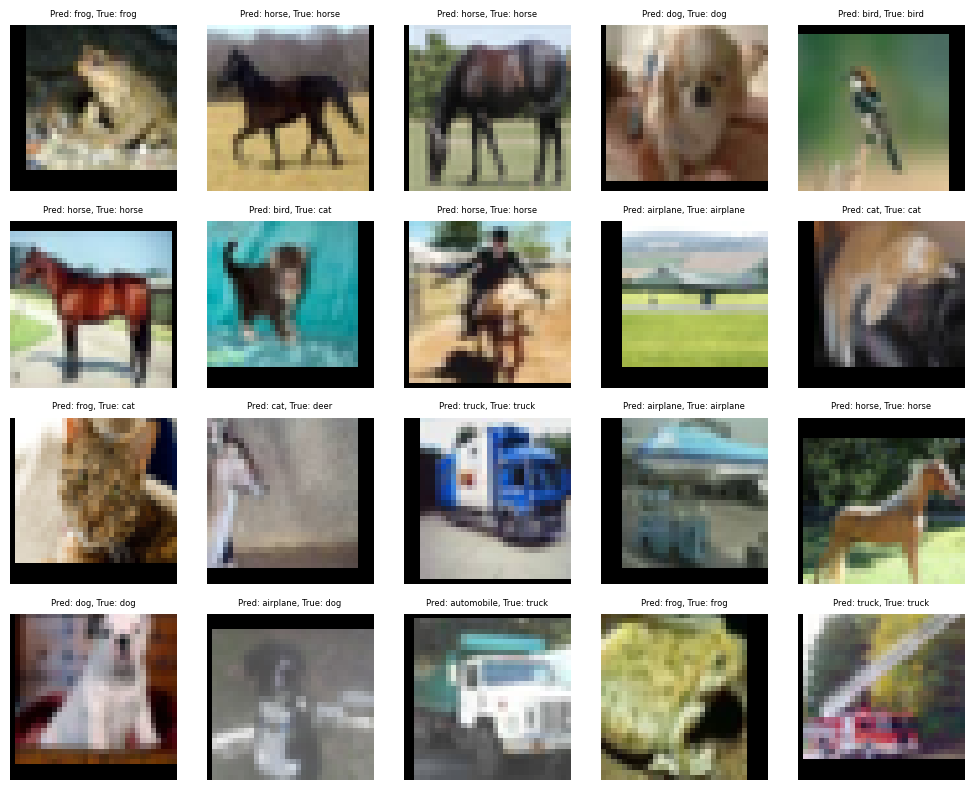

Epoch 2: Train Loss: 1.291 | Train Acc: 53.344
Test Loss: 1.190 | Test Acc: 58.450


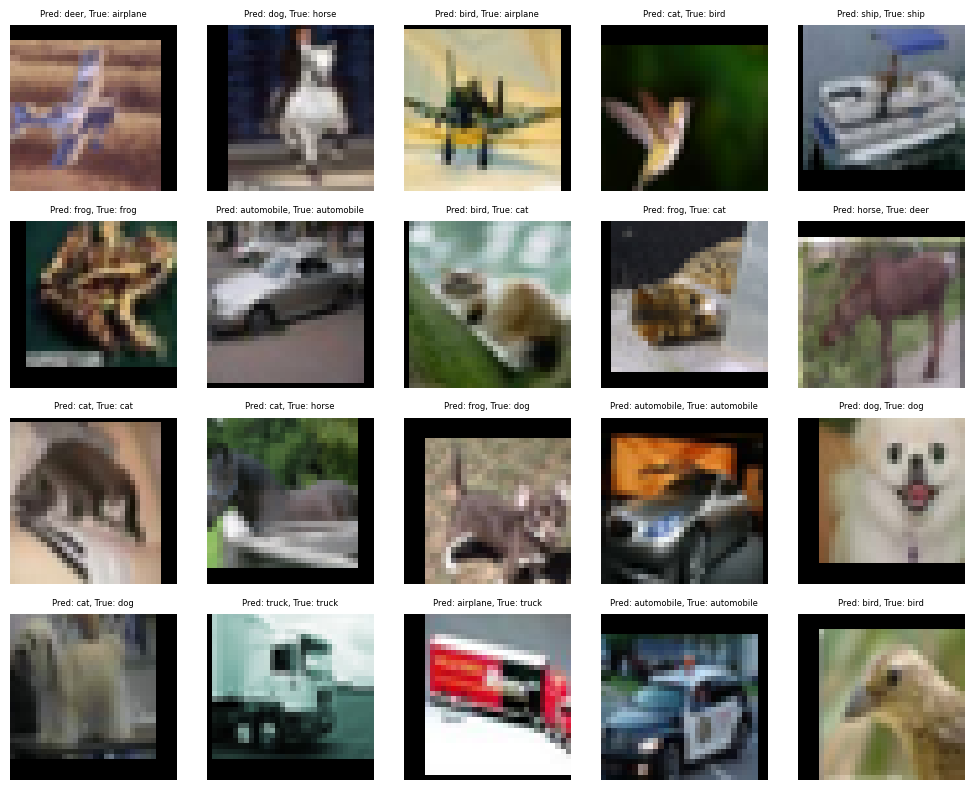

Epoch 3: Train Loss: 1.064 | Train Acc: 62.308
Test Loss: 1.013 | Test Acc: 64.530


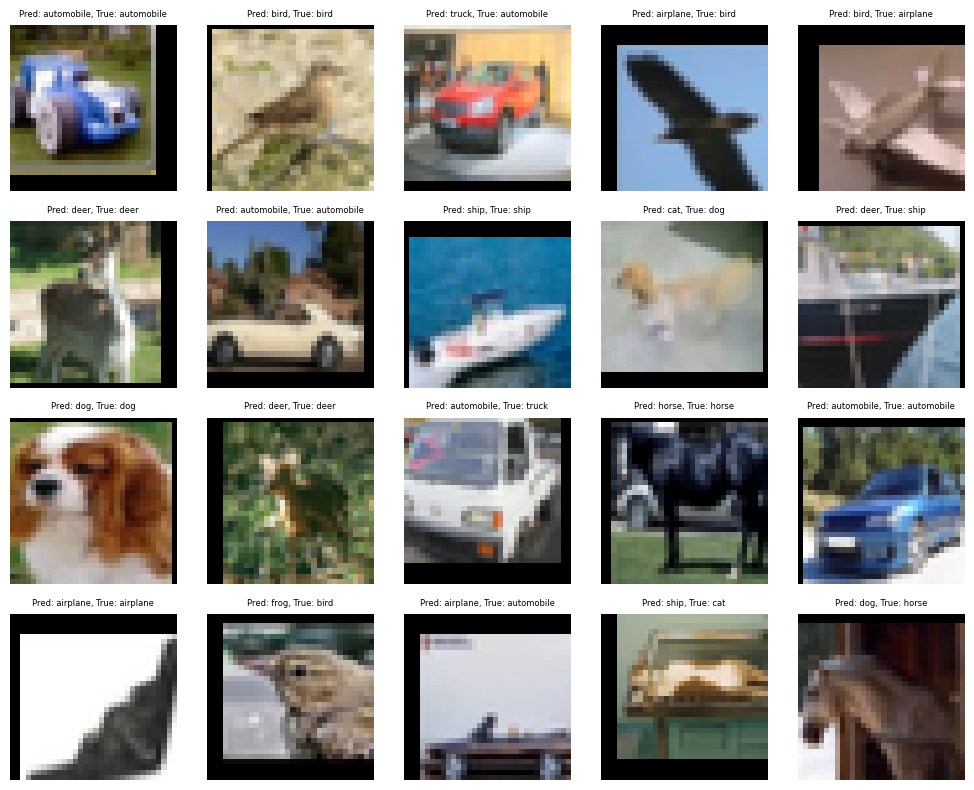

Epoch 4: Train Loss: 0.906 | Train Acc: 68.222
Test Loss: 0.890 | Test Acc: 69.310


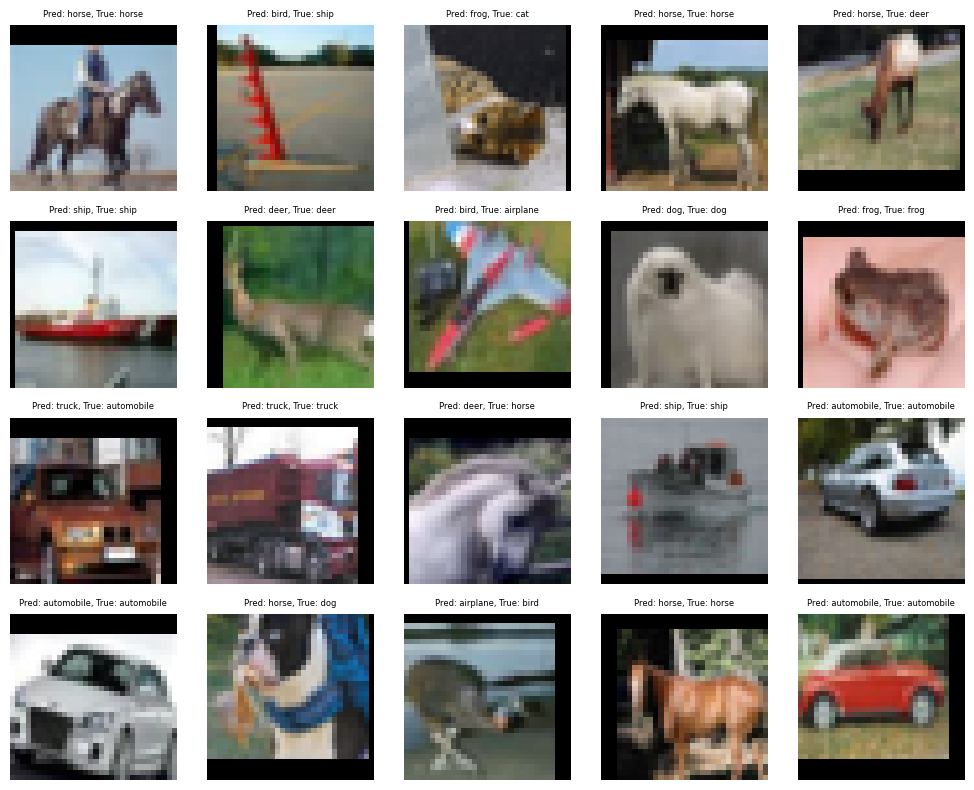

Epoch 5: Train Loss: 0.782 | Train Acc: 72.876
Test Loss: 0.793 | Test Acc: 72.480


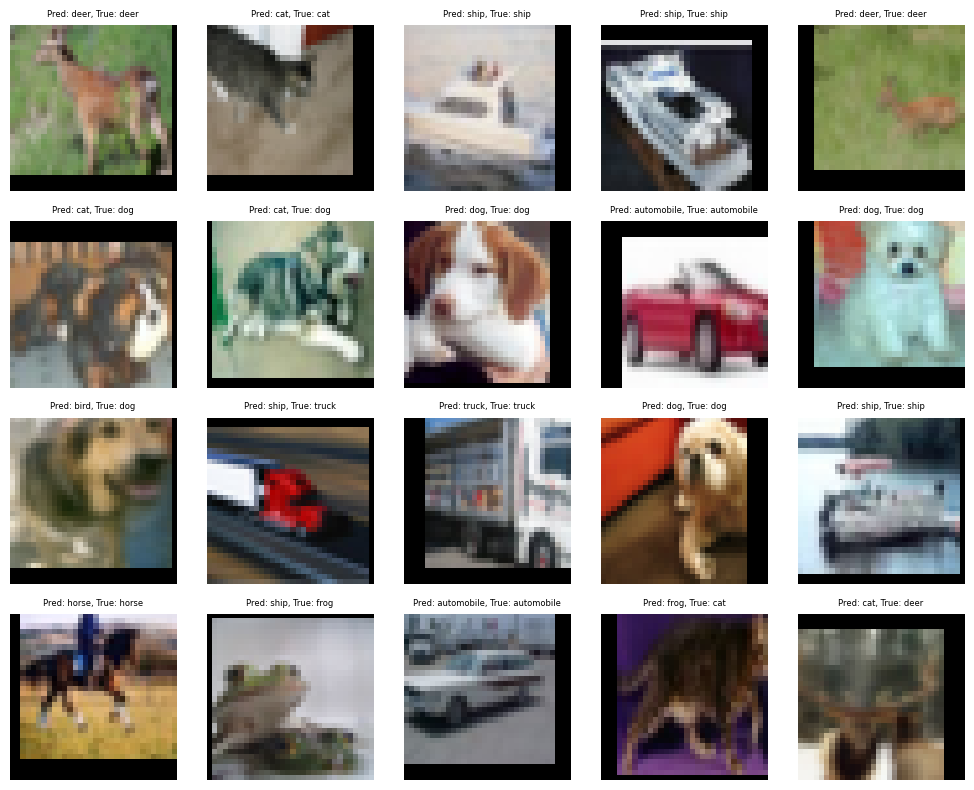

Epoch 6: Train Loss: 0.695 | Train Acc: 76.242
Test Loss: 0.756 | Test Acc: 74.900


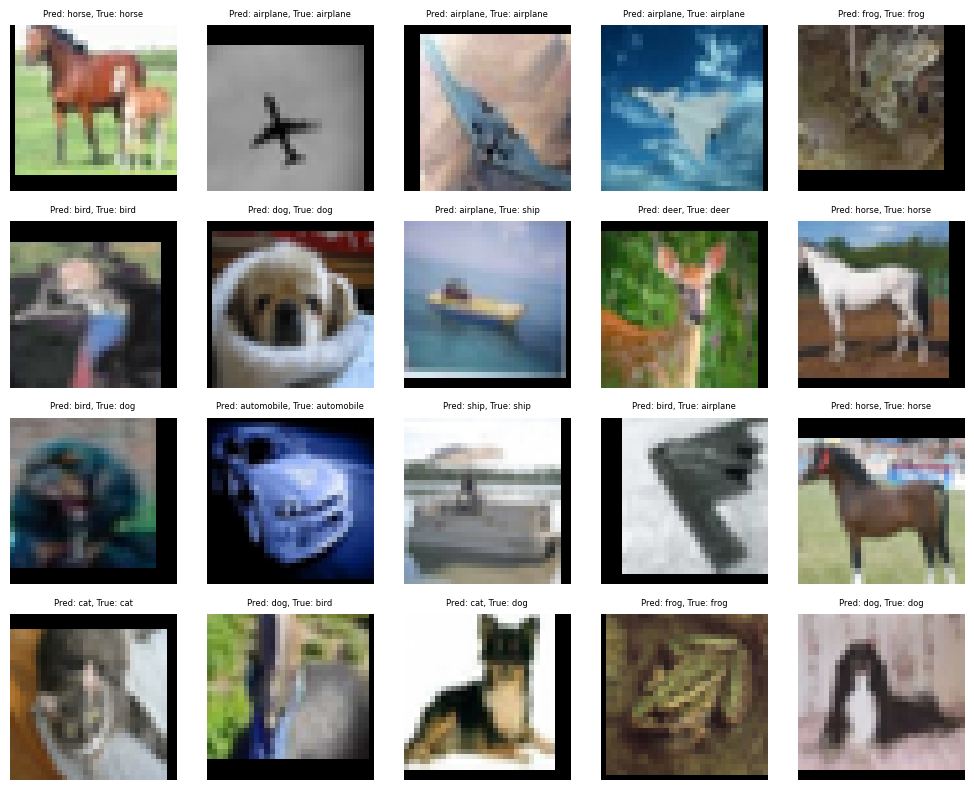

Epoch 7: Train Loss: 0.630 | Train Acc: 78.212
Test Loss: 0.673 | Test Acc: 76.800


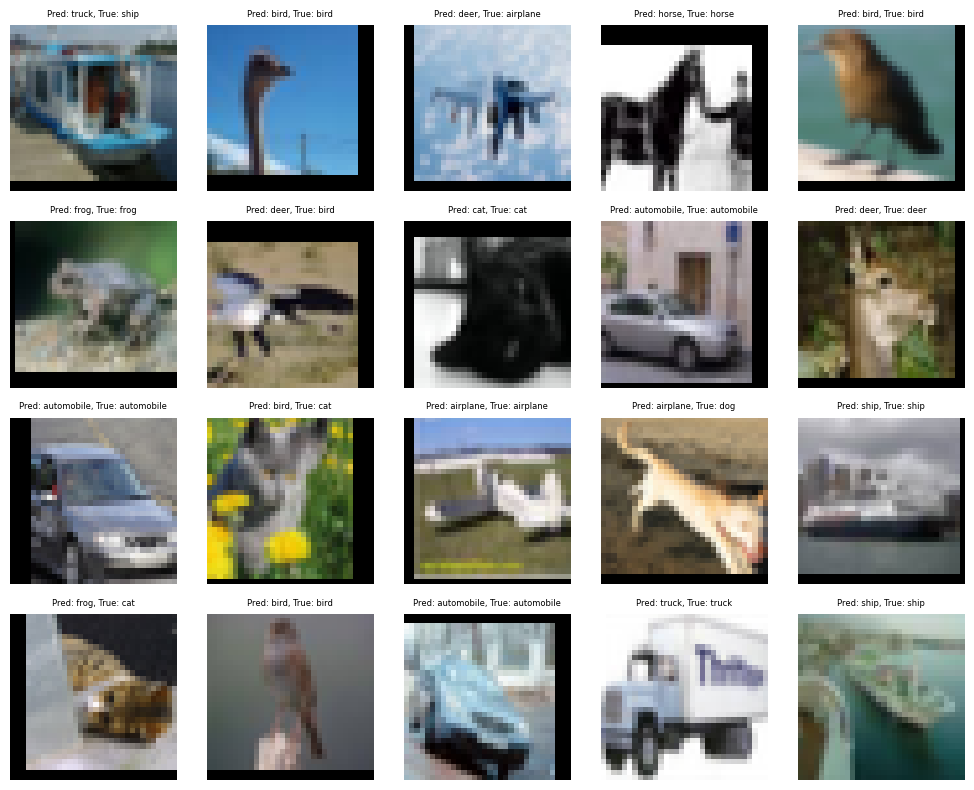

Epoch 8: Train Loss: 0.576 | Train Acc: 80.328
Test Loss: 0.622 | Test Acc: 78.960


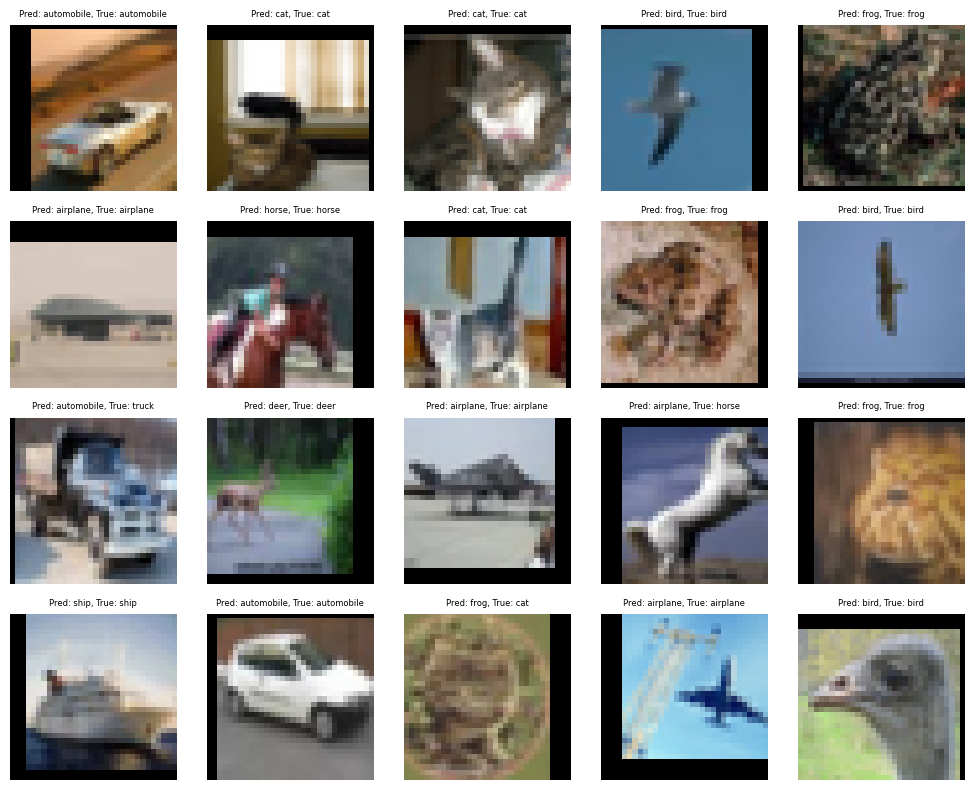

Epoch 9: Train Loss: 0.537 | Train Acc: 81.652
Test Loss: 0.581 | Test Acc: 79.980


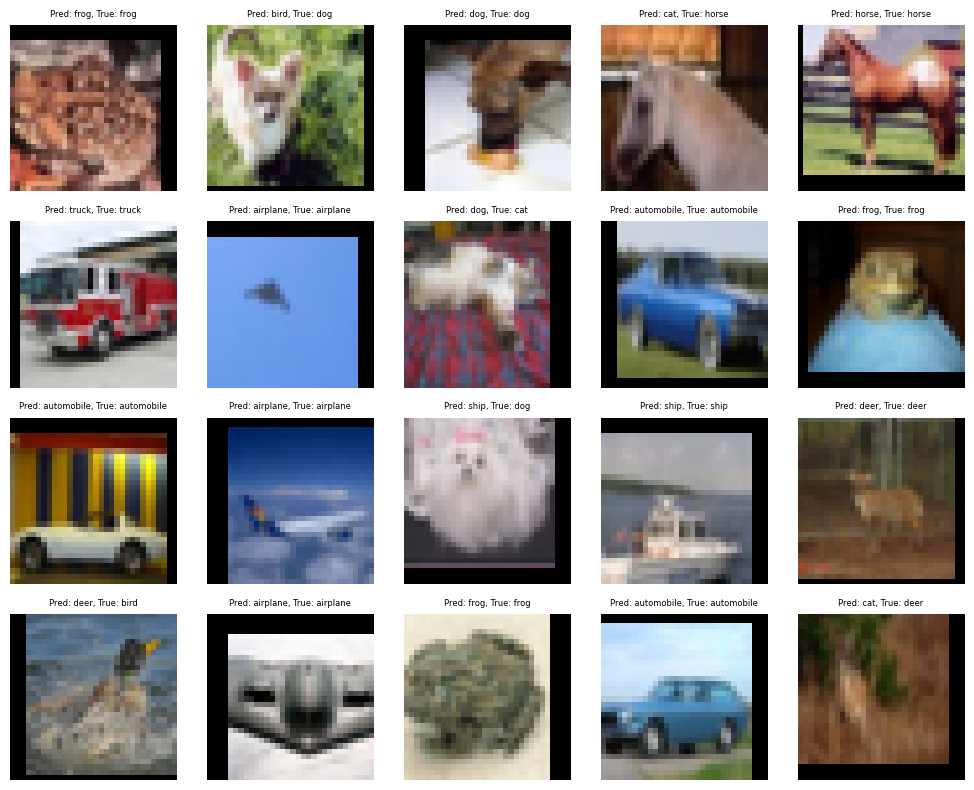

Epoch 10: Train Loss: 0.503 | Train Acc: 82.844
Test Loss: 0.565 | Test Acc: 80.410


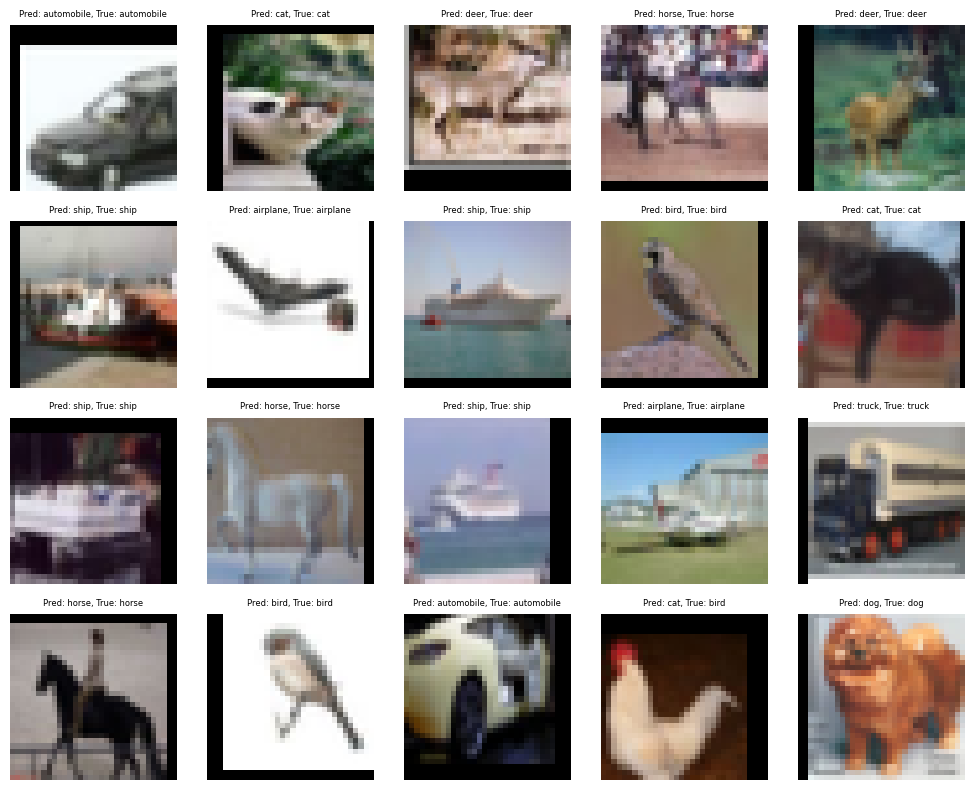

Epoch 11: Train Loss: 0.431 | Train Acc: 85.182
Test Loss: 0.488 | Test Acc: 83.300


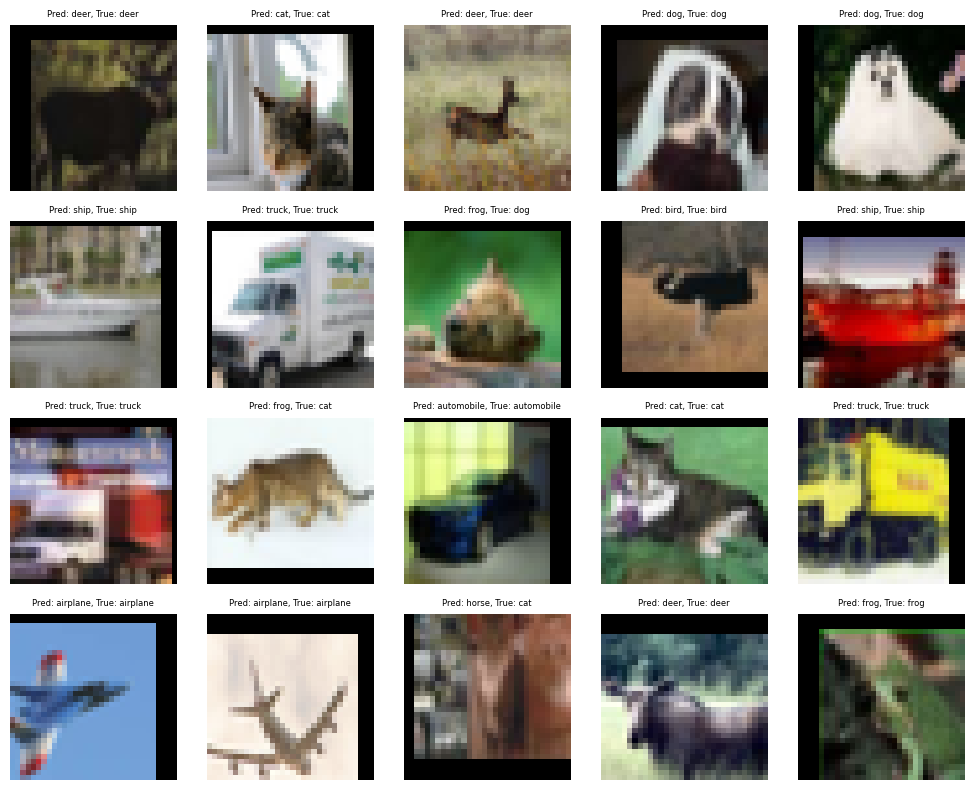

Epoch 12: Train Loss: 0.408 | Train Acc: 85.994
Test Loss: 0.450 | Test Acc: 84.240


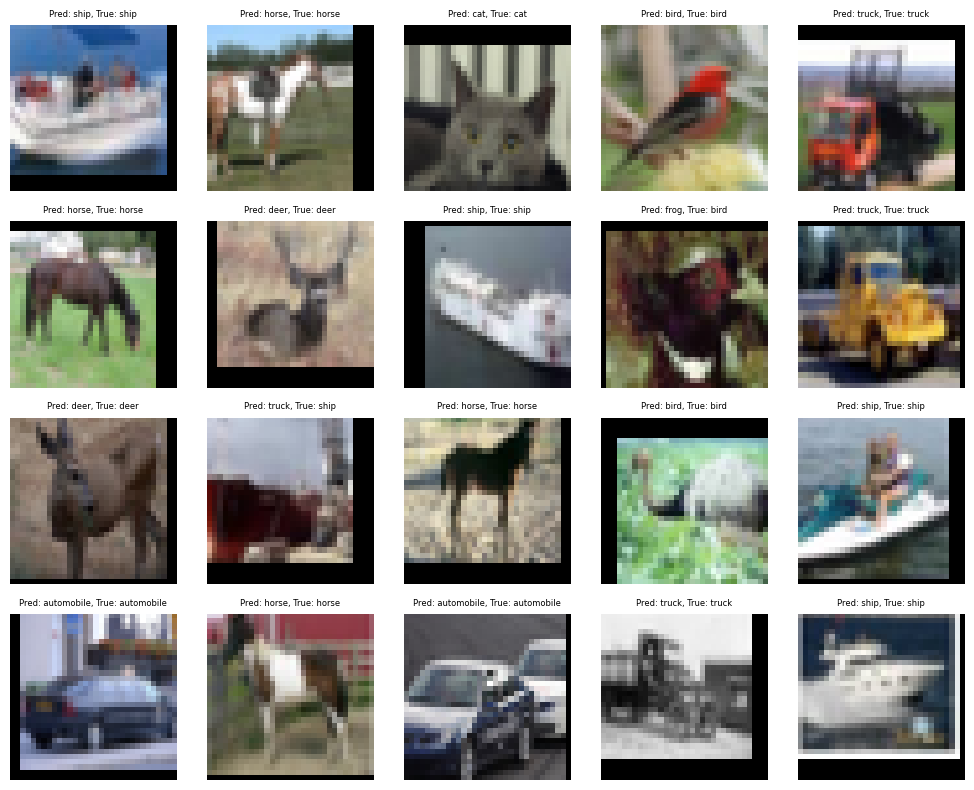

Epoch 13: Train Loss: 0.387 | Train Acc: 86.644
Test Loss: 0.458 | Test Acc: 84.520


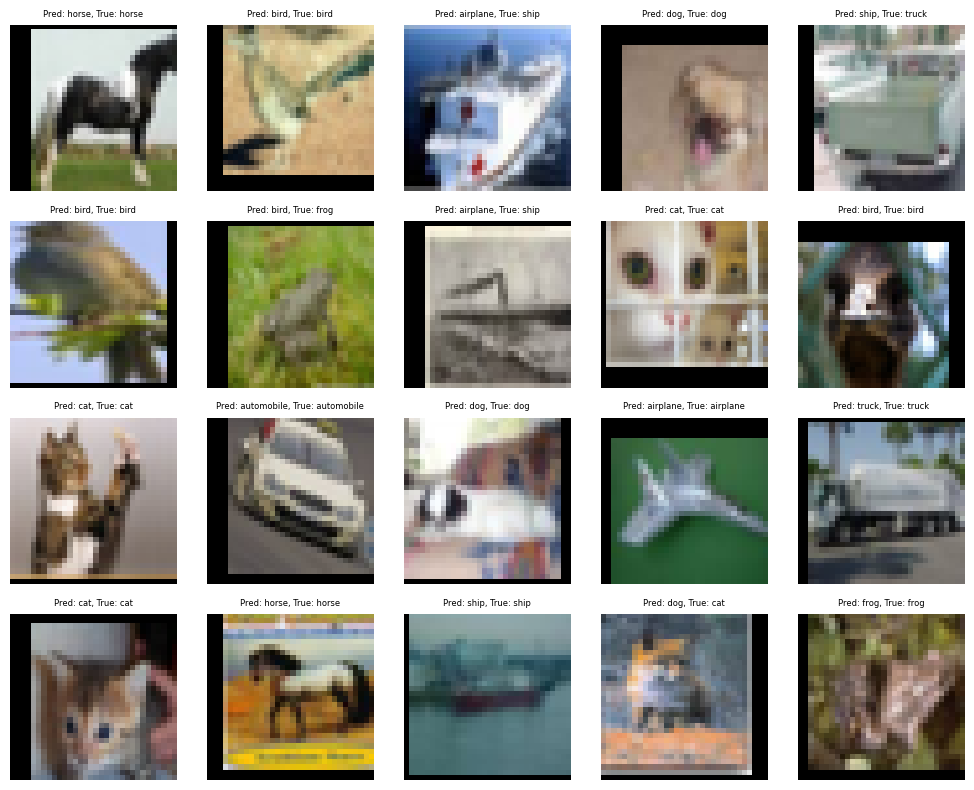

Epoch 14: Train Loss: 0.364 | Train Acc: 87.476
Test Loss: 0.469 | Test Acc: 84.190


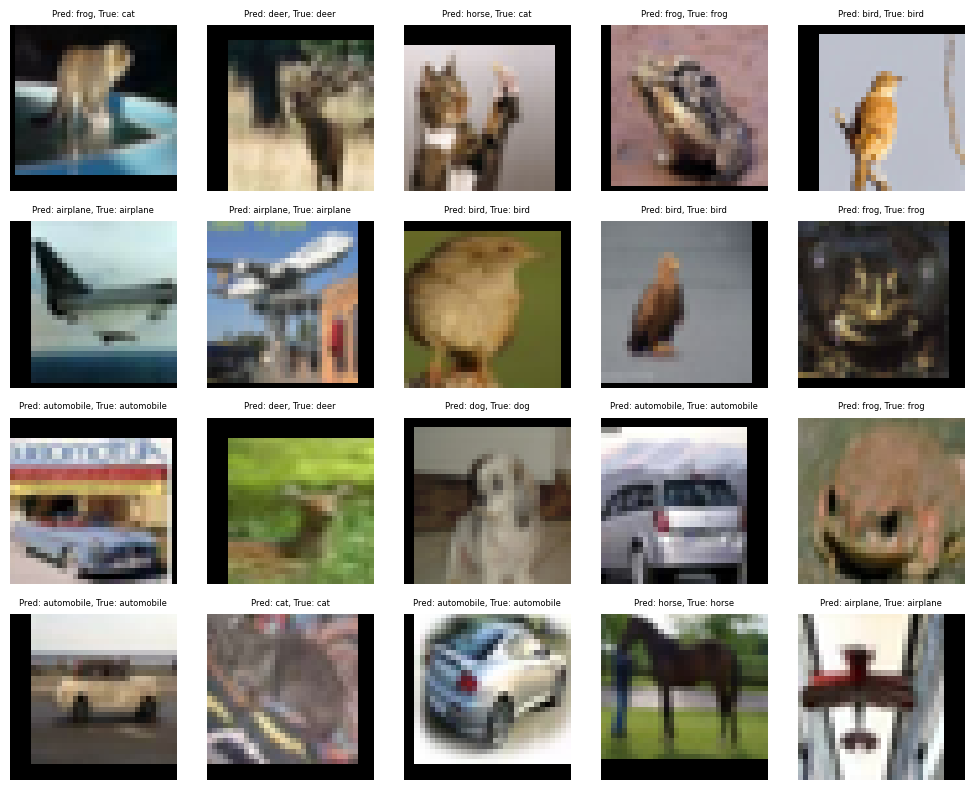

Epoch 15: Train Loss: 0.354 | Train Acc: 87.690
Test Loss: 0.439 | Test Acc: 85.420


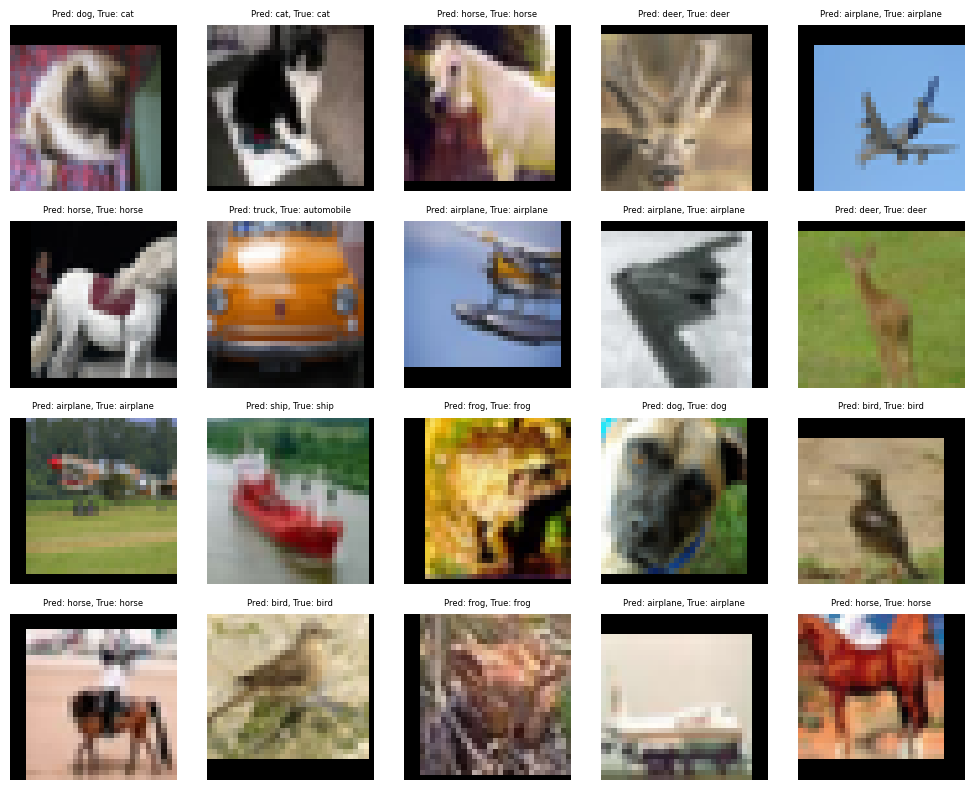

Epoch 16: Train Loss: 0.334 | Train Acc: 88.390
Test Loss: 0.434 | Test Acc: 85.930


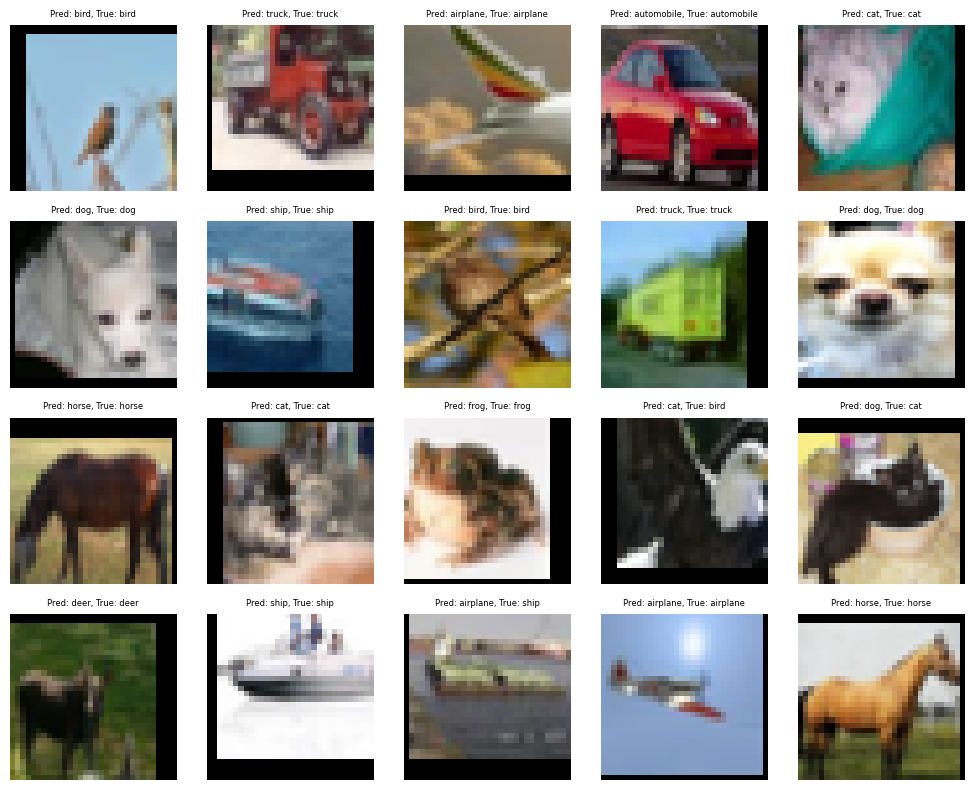

Epoch 17: Train Loss: 0.324 | Train Acc: 88.744
Test Loss: 0.432 | Test Acc: 85.620


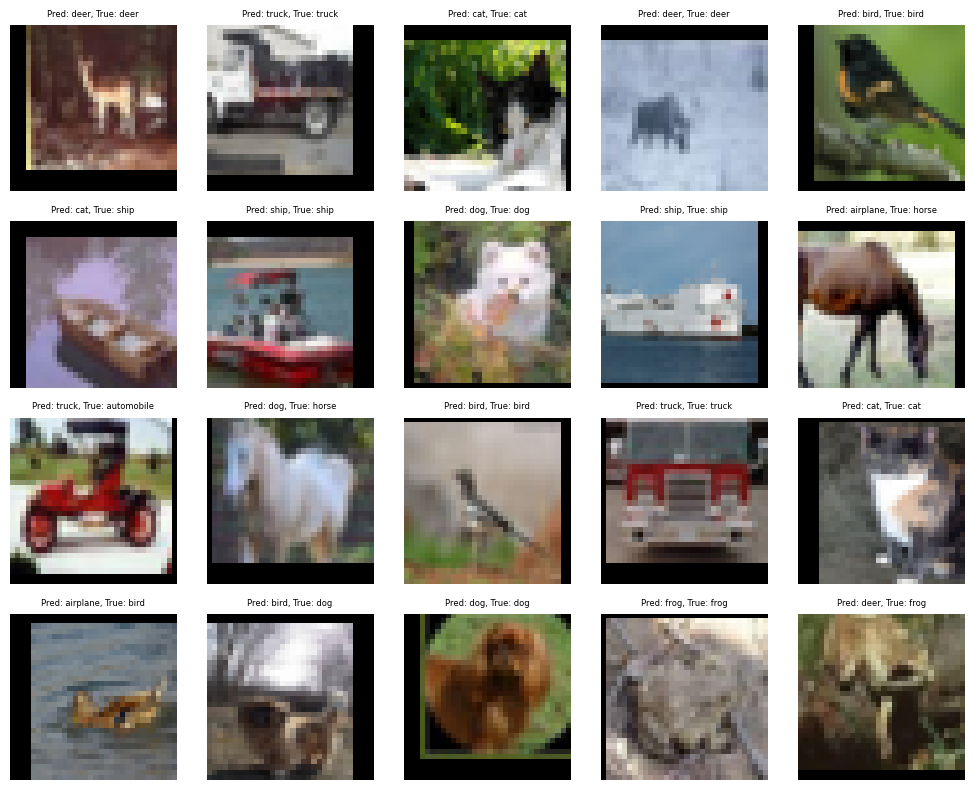

Epoch 18: Train Loss: 0.310 | Train Acc: 89.304
Test Loss: 0.454 | Test Acc: 84.900


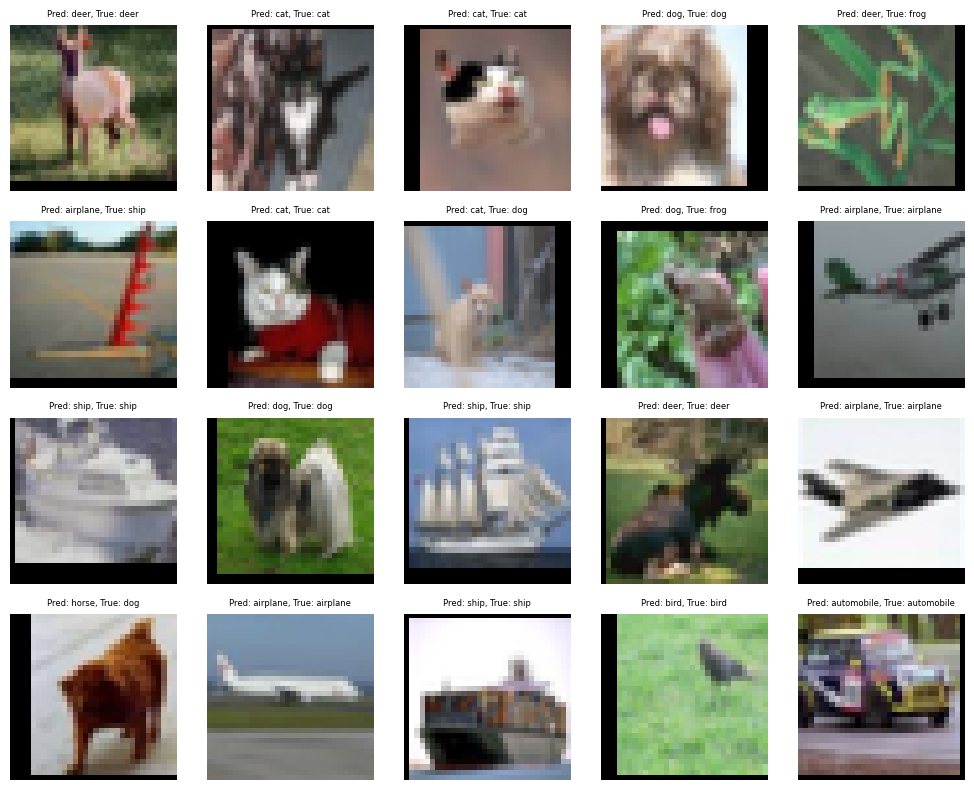

Epoch 19: Train Loss: 0.302 | Train Acc: 89.544
Test Loss: 0.423 | Test Acc: 86.300


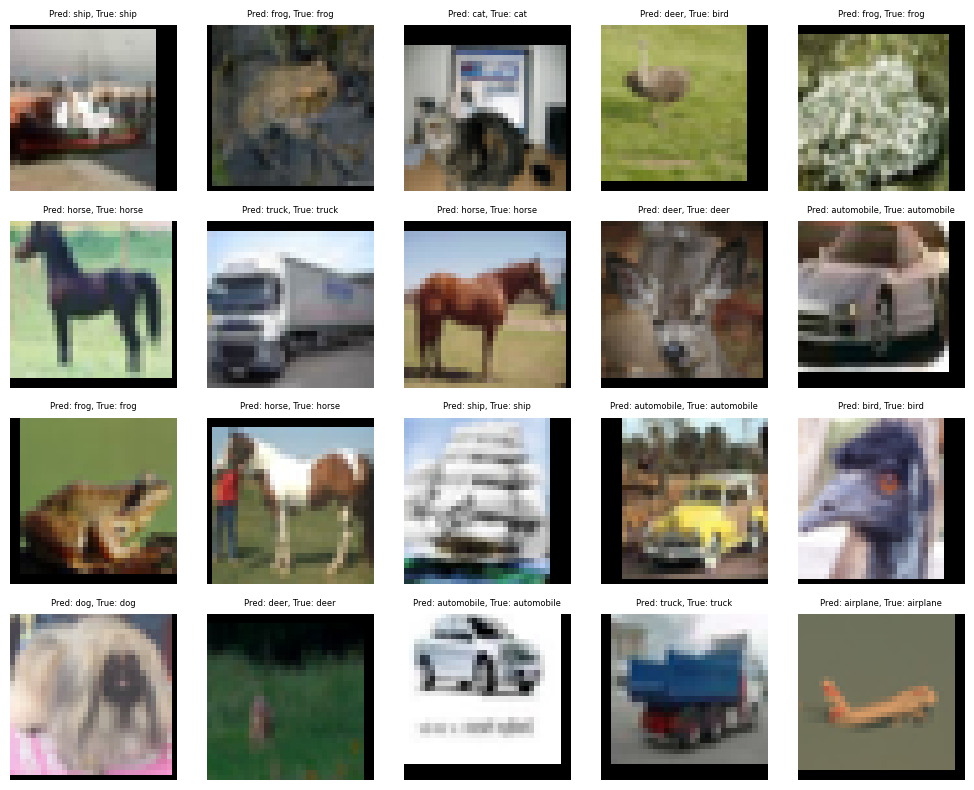

Epoch 20: Train Loss: 0.287 | Train Acc: 90.112
Test Loss: 0.406 | Test Acc: 86.560


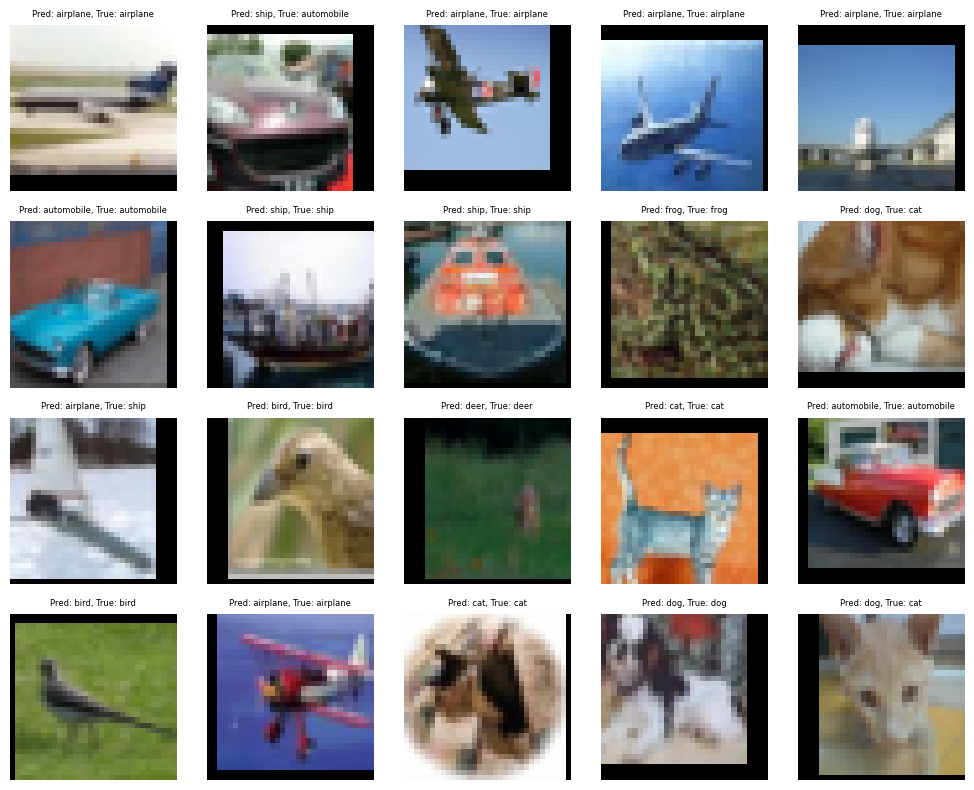

Epoch 21: Train Loss: 0.241 | Train Acc: 91.672
Test Loss: 0.386 | Test Acc: 87.400


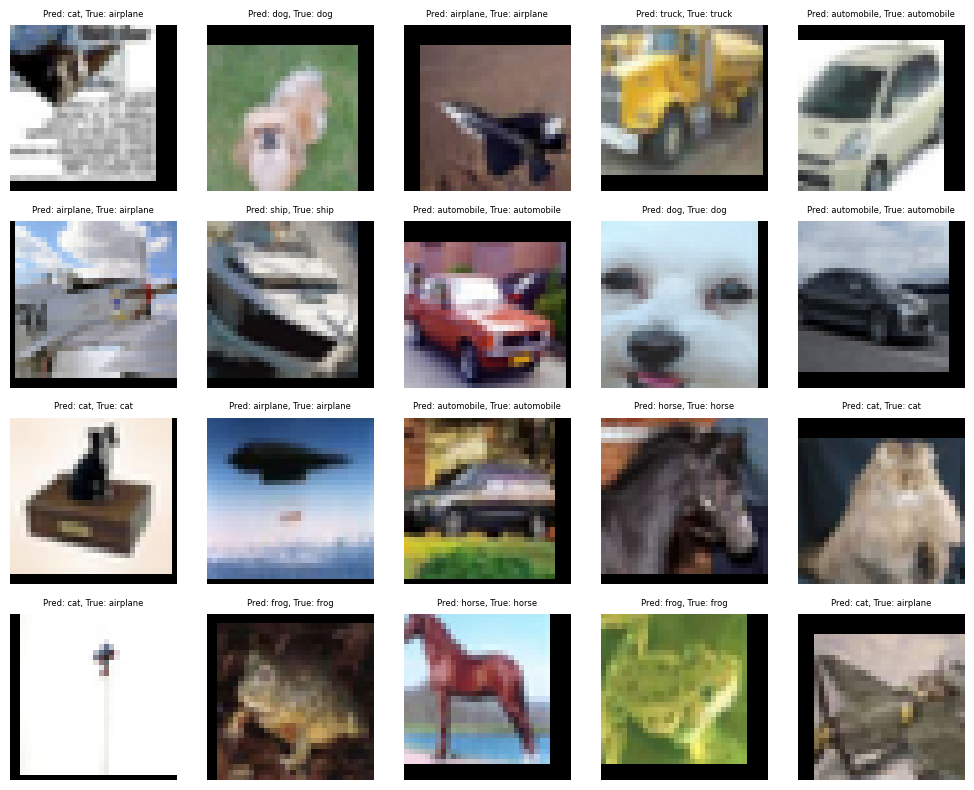

Epoch 22: Train Loss: 0.230 | Train Acc: 92.012
Test Loss: 0.390 | Test Acc: 87.290


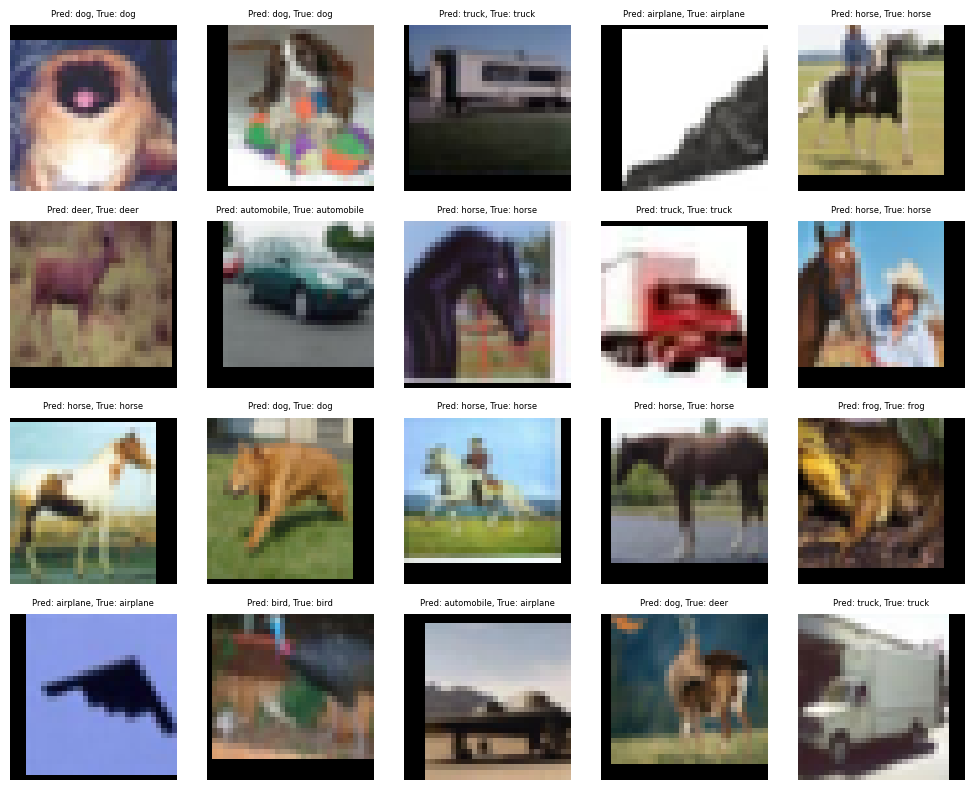

Epoch 23: Train Loss: 0.220 | Train Acc: 92.294
Test Loss: 0.386 | Test Acc: 87.700


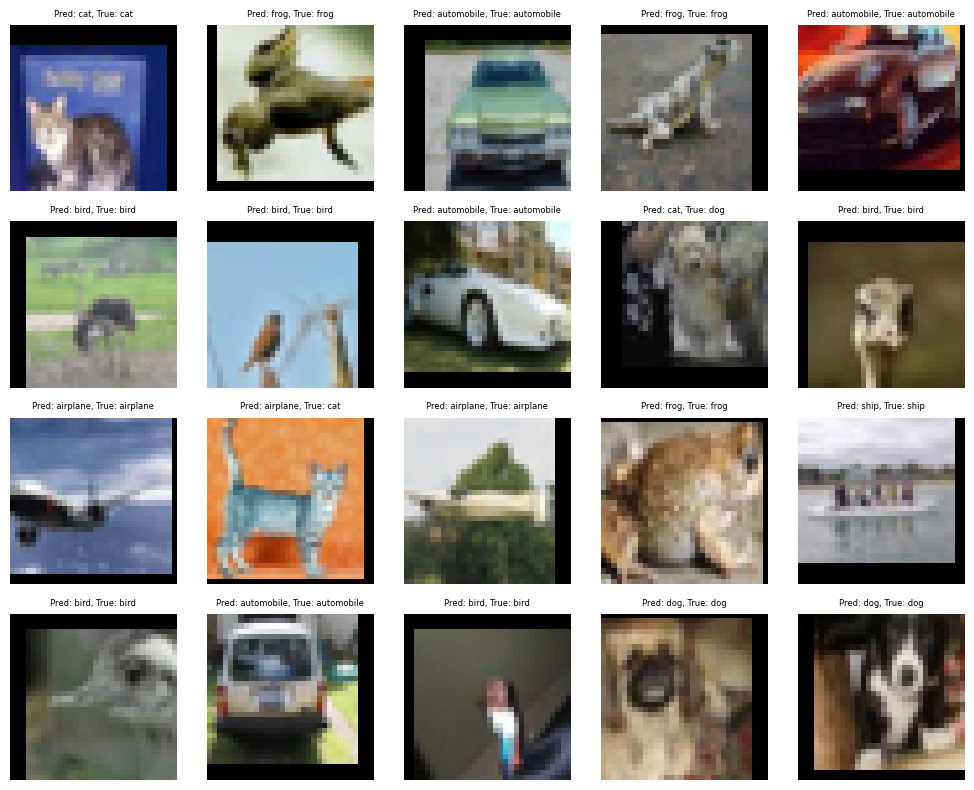

Epoch 24: Train Loss: 0.211 | Train Acc: 92.660
Test Loss: 0.385 | Test Acc: 87.520


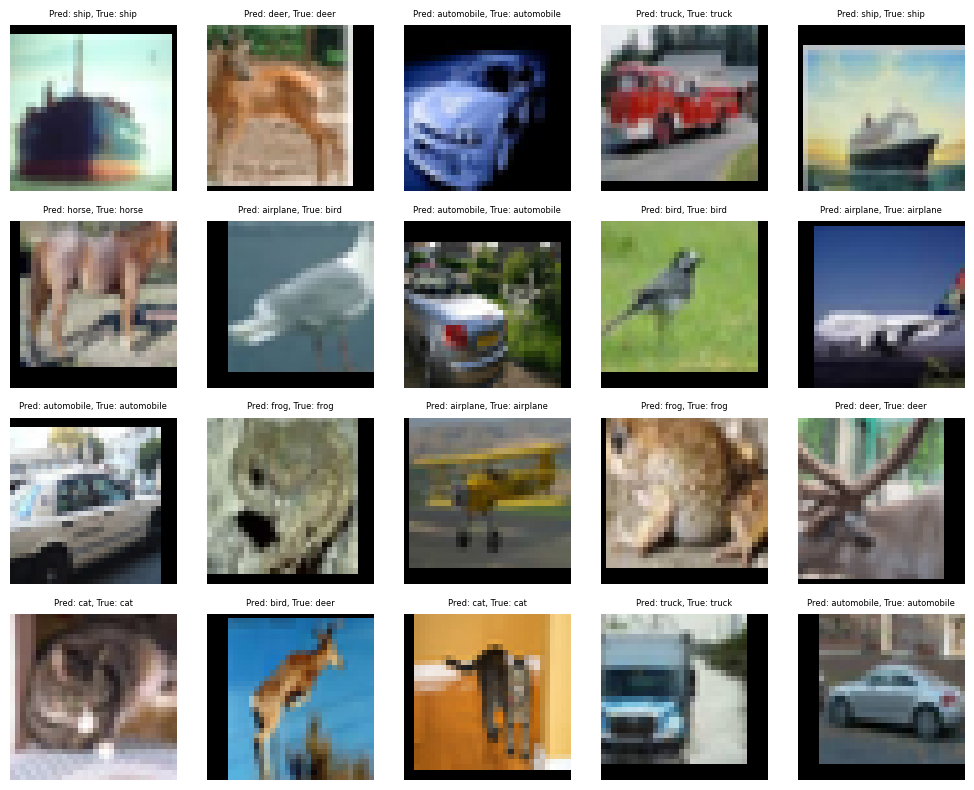

Epoch 25: Train Loss: 0.204 | Train Acc: 92.936
Test Loss: 0.371 | Test Acc: 88.030


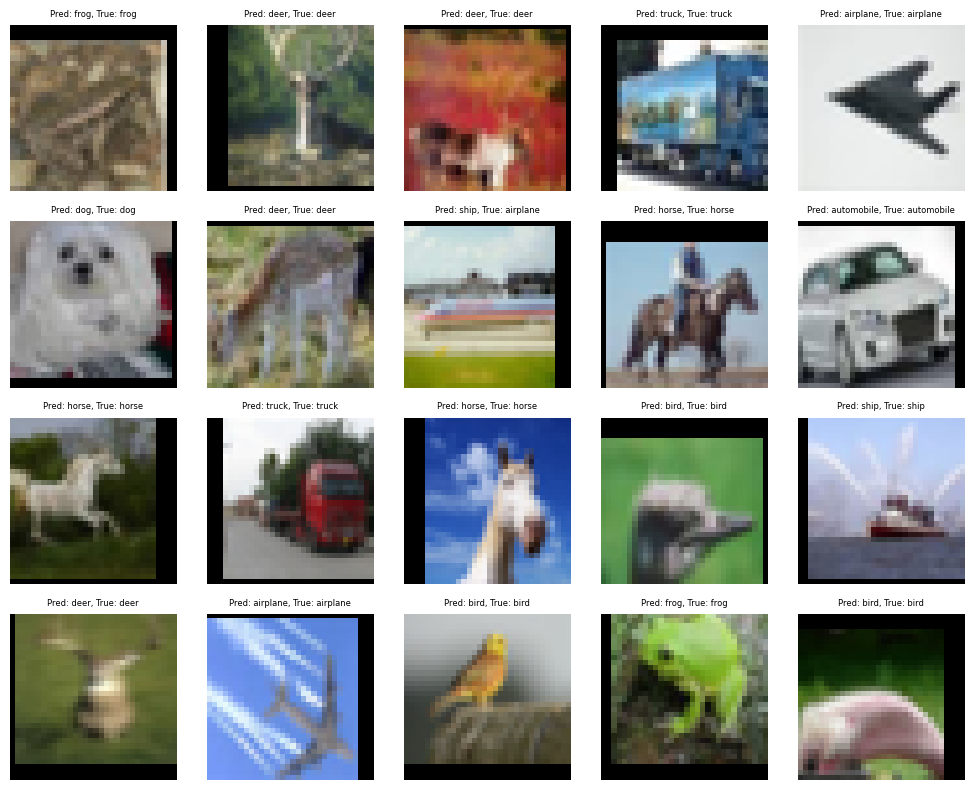

Epoch 26: Train Loss: 0.202 | Train Acc: 93.040
Test Loss: 0.364 | Test Acc: 88.760


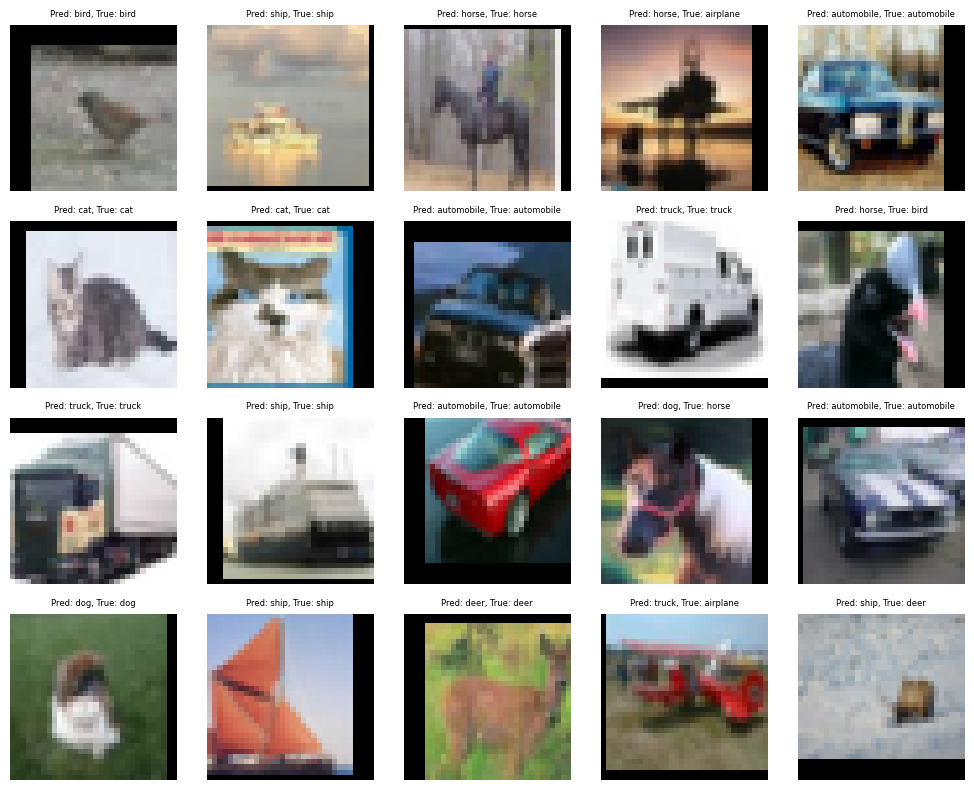

Epoch 27: Train Loss: 0.191 | Train Acc: 93.134
Test Loss: 0.370 | Test Acc: 88.440


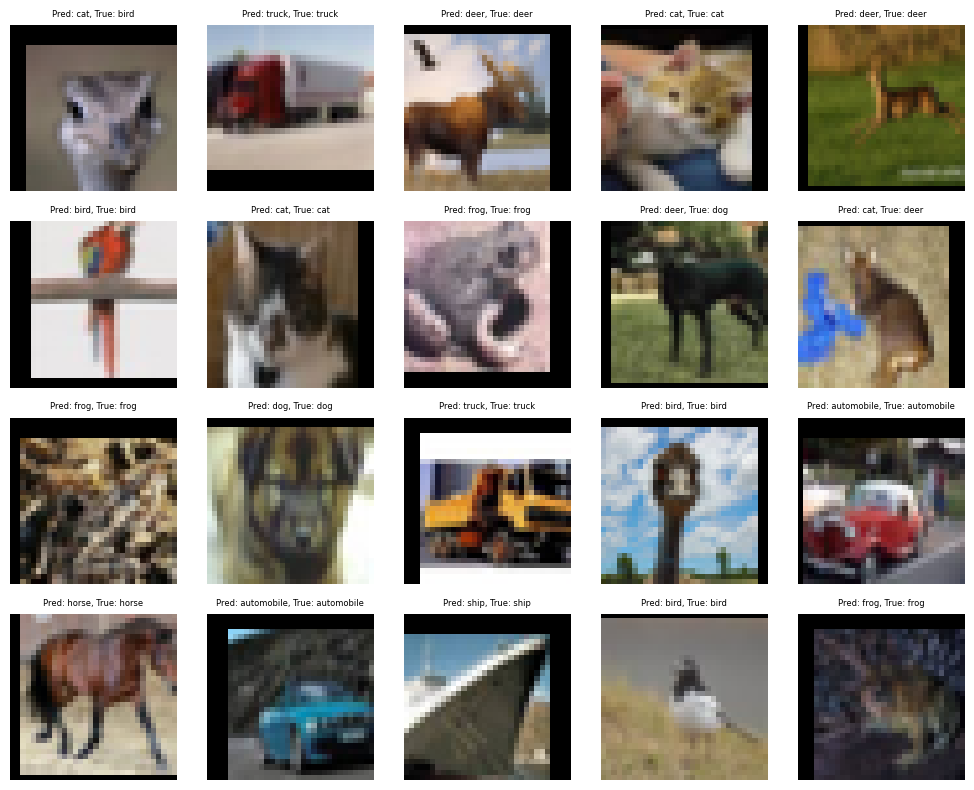

Epoch 28: Train Loss: 0.186 | Train Acc: 93.558
Test Loss: 0.379 | Test Acc: 88.700


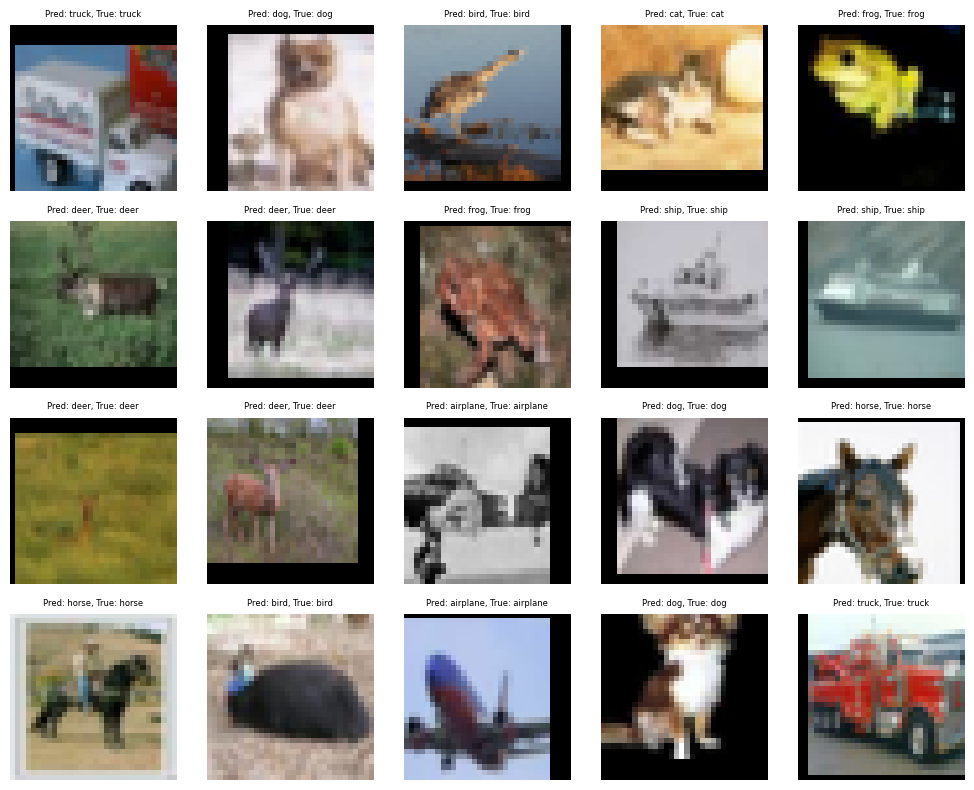

Epoch 29: Train Loss: 0.181 | Train Acc: 93.634
Test Loss: 0.400 | Test Acc: 87.500


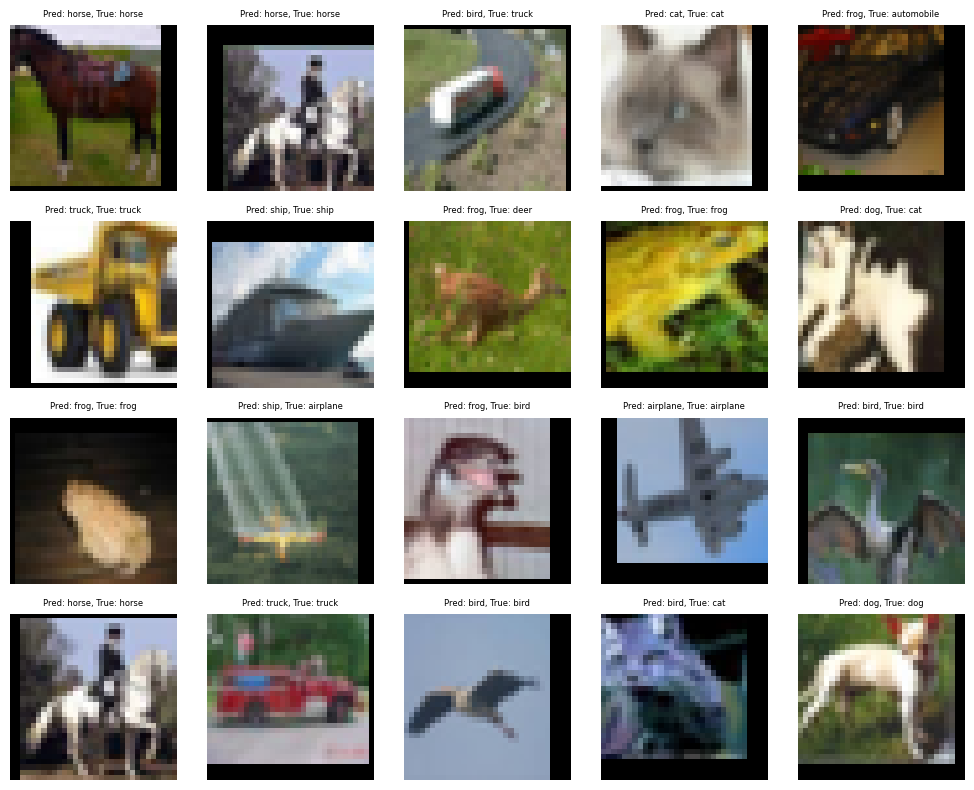

Epoch 30: Train Loss: 0.173 | Train Acc: 93.948
Test Loss: 0.383 | Test Acc: 88.400


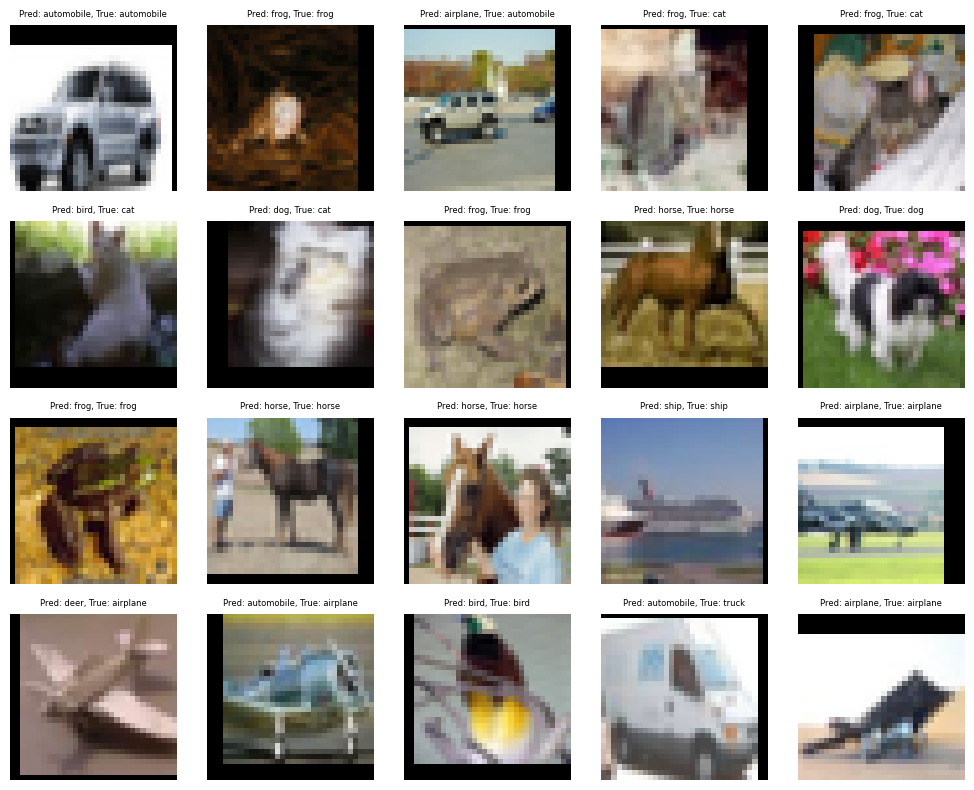

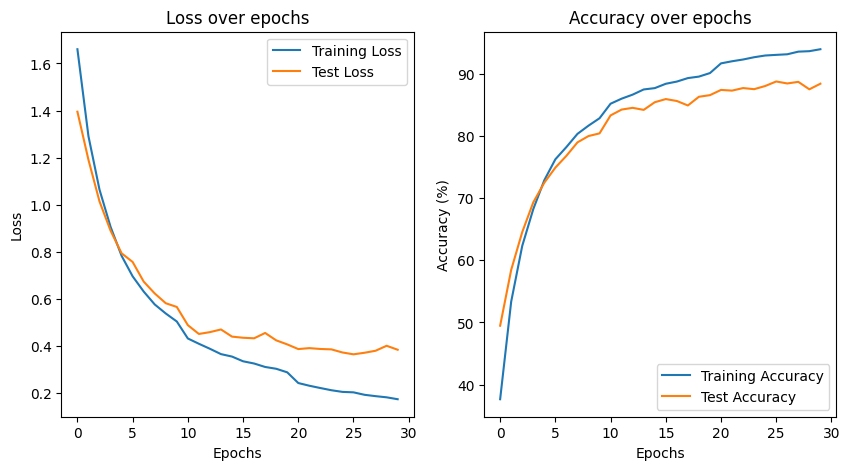

In [19]:
 # Check if the script is being executed directly
# If so, run the train_and_evaluate function with the specified class names
if __name__ == '__main__':
    train_and_evaluate(class_names)
